In [62]:
import os
import re
import time
from bs4 import BeautifulSoup
import requests
import json
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
import random
import pandas as pd

In [14]:
### 辅助函数
# 获取主页详情页链接
def get_detail_page_url(driver):
    """获取详情页链接"""
   # 定位包含详情按钮的所有<tr>元素
    rows = driver.find_elements(By.CSS_SELECTOR, "tr.ant-table-row")
    return rows
# 跳转到下一页
def step_next_page(driver):
    """跳转下一页"""
    # 使用类名和属性选择器
    next_page_button = driver.find_element(By.CSS_SELECTOR, "li.ant-pagination-next[title='下一页']")
    next_page_button.click()
    # # 使用XPath
    # next_page_button = driver.find_element(By.XPATH, "//li[@class='ant-pagination-next' and @title='下一页']")
    # next_page_button.click()
    # # 使用类名
    # next_page_button = driver.find_element(By.CLASS_NAME, "ant-pagination-next")
    # next_page_button.click()

# 从详情页返回到主页
def step_back_to_home(driver):
    button = driver.find_element(By.XPATH,"//button[span='返回']")
    button.click()


In [4]:
# 配置浏览器
# chrome.exe --remote-debugging-port=9999 --user-data-dir="D:\Selenium\AutomationProfile"
# chrome.exe --remote-debugging-port=9999 --user-data-dir="D:\Program Files\ChromeDir"
options = webdriver.ChromeOptions()
options.add_experimental_option("debuggerAddress", "localhost:9999")
driver = webdriver.Chrome(options=options)
driver.implicitly_wait(20)

In [11]:
# 定位包含详情按钮的所有<tr>元素
rows = driver.find_elements(By.CSS_SELECTOR, "tr.ant-table-row")

In [12]:
rows

[<selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.158")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.159")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.160")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.161")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.162")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601

In [15]:
# 遍历每个<tr>元素
for row in rows:
    # 在每个<tr>元素中定位详情按钮
    detail_button = row.find_element(By.CSS_SELECTOR, "button.ant-btn.ant-btn-link.ant-btn-lg")
    
    # 点击详情按钮
    detail_button.click()
    
    # 处理详情页内容，可能需要等待内容加载
    time.sleep(2)  # 根据实际情况调整等待时间

    # 从详情页返回
    step_back_to_home(driver)


In [16]:
image_elements = driver.find_elements(By.TAG_NAME, "img")

In [74]:
image_elements,len(image_elements)

([<selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.61")>,
  <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.62")>,
  <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.63")>,
  <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.129")>,
  <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.D369FC30245943D45A58A3FAC470EA38.e.130")>,
  <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea

https://sanpu.iarrp.cn/assets/logo.8c5debb3.svg
https://sanpu.iarrp.cn/images/home/pending-work.png
https://sanpu.iarrp.cn/images/home/quality.png
https://sanpu.iarrp.cn/images/workpanel/btn-auditing2.png
https://sanpu.iarrp.cn/images/workpanel/btn-audit.png

https://sanpu.iarrp.cn/images/workpanel/place.svg
https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/123f45ef-be7f-4f19-a7bd-cf27aea799ac.jpg
https://sanpu.iarrp.cn/images/workpanel/photo.svg
https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709111332&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=S1zTvNbsVlEBix4r3lqPonUHujk%3D
https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/9c4f7803-f397-4912-b54d-fab7c1ce325b.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709111332&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=h1MyvrFFPAdGaAhNsVOaO0j6lL4%3D
https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/e482b11c-aecc-4eea-
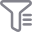

In [18]:
# 提取所有图片的src属性，即它们的链接
image_urls = [image.get_attribute('src') for image in image_elements]

# 输出图片链接
for url in image_urls:
    print(url)

In [67]:
images_info = driver.execute_script("""
    var images = [];
    var imageElements = document.querySelectorAll('div.card-box div.ant-image img');
    imageElements.forEach(function(img) {
        var labelElement = img.nextElementSibling;
        var label = labelElement ? labelElement.innerText : '';
        images.push({'url': img.src, 'label': label});
    });
    return images;
""")
for info in images_info:
    print(info)


{'label': '预览', 'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=qB205cT30BiTA2Oq9PVYZKs7Vuc%3D'}
{'label': '预览', 'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/9c4f7803-f397-4912-b54d-fab7c1ce325b.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=D3d78O%2F8g8GRXrmkTdHem%2BqF69Y%3D'}
{'label': '预览', 'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/e482b11c-aecc-4eea-b3cc-d8834de39dfe.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=sojnicXUU8Y25b4fg1d5LGOhQkc%3D'}
{'label': '预览', 'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/2efd71c0-6825-4eb1-8c9b-e5ae8a3ef853.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%

In [66]:
import re
html_source = driver.page_source
pattern = re.compile(r'<div class="ant-image"[^>]*><img[^>]+src="([^"]+)"[^>]*>.*?<div class="img-text"[^>]*>([^<]+)</div>', re.DOTALL)
matches = pattern.findall(html_source)
for match in matches:
    print({'url': match[0], 'label': match[1]})


{'url': 'https://sanpu.iarrp.cn:443/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&amp;Expires=1709114951&amp;x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&amp;Signature=qB205cT30BiTA2Oq9PVYZKs7Vuc%3D', 'label': '景观照片-东'}
{'url': 'https://sanpu.iarrp.cn:443/ssp-dccy/2023-12-13/522722/9c4f7803-f397-4912-b54d-fab7c1ce325b.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&amp;Expires=1709114951&amp;x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&amp;Signature=D3d78O%2F8g8GRXrmkTdHem%2BqF69Y%3D', 'label': '景观照片-南'}
{'url': 'https://sanpu.iarrp.cn:443/ssp-dccy/2023-12-13/522722/e482b11c-aecc-4eea-b3cc-d8834de39dfe.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&amp;Expires=1709114951&amp;x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&amp;Signature=sojnicXUU8Y25b4fg1d5LGOhQkc%3D', 'label': '景观照片-西'}
{'url': 'https://sanpu.iarrp.cn:443/ssp-dccy/2023-12-13/522722/2efd71c0-6825-4eb1-8c9b-e5ae8a3ef853.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&a

In [79]:

# 获取“下一张”按钮
next_button = driver.find_element(By.CSS_SELECTOR, 'div.swiper-button-next')

images_info = []
num_images = len(driver.find_elements(By.CSS_SELECTOR, 'div.card-box div.ant-image img'))

# 遍历图片集合
for _ in range(num_images):
    # 等待图片和标签信息更新
    # time.sleep(1)  # 根据实际情况调整等待时间

    # 获取当前显示的图片URL和标签信息
    img = driver.find_element(By.CSS_SELECTOR, 'div.card-box div.ant-image img')
    labelDiv = driver.find_element(By.CSS_SELECTOR, "div.green-area")
    labelType = labelDiv.find_element(By.CSS_SELECTOR, "div.photo > div:first-child").text.replace('照片类型: ', '').strip()
    labelAngle = labelDiv.find_element(By.CSS_SELECTOR, "div.photo > div:last-child").text.replace('拍摄角度: ', '').strip()
    labelTime = labelDiv.find_element(By.CSS_SELECTOR, ".time-area").text.replace('拍摄时间: ', '').strip()

    images_info.append({
        'url': img.get_attribute('src'),
        'label': {'type': labelType, 'angle': labelAngle, 'time': labelTime}
    })

    # 点击“下一张”按钮
    try:
        next_button.click()
    except:
        pass

# 输出获取到的图片信息
for info in images_info:
    print(info)

{'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=qB205cT30BiTA2Oq9PVYZKs7Vuc%3D', 'label': {'type': '景观照片-北', 'angle': '358°（北）', 'time': '2023-12-13 11:43:17'}}
{'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=qB205cT30BiTA2Oq9PVYZKs7Vuc%3D', 'label': {'type': '景观照片-东', 'angle': '92°（东）', 'time': '2023-12-13 11:45:56'}}
{'url': 'https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709114951&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=qB205cT30BiTA2Oq9PVYZKs7Vuc%3D', 'label': {'type': '景观照片-南', 'angle': '183°（南）', 'time': '2023-12-13 11:44:36'}}
{'url': 

In [72]:
images_info = []
num_images = driver.find_elements(By.CSS_SELECTOR, 'div.card-box div.ant-image img')

In [73]:
num_images

[<selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.352B1B3355F25C745E5B21702E11EDFA.e.13209")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.352B1B3355F25C745E5B21702E11EDFA.e.13210")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.352B1B3355F25C745E5B21702E11EDFA.e.13211")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.352B1B3355F25C745E5B21702E11EDFA.e.13212")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d556fa23ea601795f50d257c3", element="f.77AB10D290551153FEA3F1C9C4B9B3A5.d.352B1B3355F25C745E5B21702E11EDFA.e.13213")>,
 <selenium.webdriver.remote.webelement.WebElement (session="9897702d55

In [23]:

# 等待并点击下拉选择的触发器以展开选项列表
dropdown_trigger = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, 'div.ant-select-selector'))
)
dropdown_trigger.click()

# 增加一些等待时间，确保下拉列表的选项加载完成

# 等待并定位到特定的选项（例如“混合点照片”）
option_to_select = WebDriverWait(driver, 10).until(
    EC.visibility_of_element_located((By.XPATH, "//div[contains(@class, 'ant-select-item-option-content') and contains(text(), '混样点照片')]"))
)
option_to_select.click()


TimeoutException: Message: 


In [ ]:

# 定位所有包含文本的元素
text_elements = driver.find_elements(By.XPATH, '//*[text()]')

# # 提取并打印每个元素的文本
for element in text_elements:
    print(element.text)

In [ ]:
sections = driver.find_elements(By.CSS_SELECTOR, '.ldtj-content')

for section in sections:
    # 获取当前部分的所有子元素，这些子元素包含了我们需要的信息
    items = section.find_elements(By.XPATH, './*')
    for item in items:
        # 假设键（例如“天气:”）在<span class="gray-color">里，而值紧跟在<span>后面
        key = item.find_element(By.CSS_SELECTOR, 'span.gray-color').text
        # 获取整个item的文本，这将包含键和值
        full_text = item.text
        # 值是全文本去掉键的部分
        value = full_text.replace(key, '').strip()
        print(f'{key} {value}')

In [104]:
# 下拉选择对应元素图片
def select_element_image(driver, element_name):

    # 定位
    span_element = driver.find_element(By.XPATH, "//div[@class='ant-select select-width ant-select-single ant-select-allow-clear ant-select-show-arrow']")
    span_element.click()
    # 选择对应标签
    option = driver.find_element(By.XPATH,f'//div[@title="{element_name}"]')
    option.click()
        # 点击清空
    body = driver.find_element(By.TAG_NAME, 'body')
    body.click()
    body.click()


In [105]:
select_element_image(driver, "景观照片")

In [65]:


# 创建ActionChains对象
actions = ActionChains(driver)

# 移动到一个相对安全的位置并点击
# actions.move_by_offset(10, 10).click().perform()
actions.click().perform()


In [81]:


# 定位到包含图片的div
container_div = driver.find_element(By.CSS_SELECTOR, 'div.scroll-xxxx.h-full[data-v-b41b232c]')

# 找到所有的img标签
images = container_div.find_elements(By.TAG_NAME, 'img')

# 遍历每一个img标签
for img in images:
    # 获取图片的src属性（图片链接）
    src = img.get_attribute('src')
    
    # 获取其他你感兴趣的属性，例如alt
    alt = img.get_attribute('alt')
    
    # 打印信息
    print(f'Image SRC: {src}, ALT: {alt}')

Image SRC: https://sanpu.iarrp.cn/images/workpanel/photo.svg, ALT: 
Image SRC: https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/2efd71c0-6825-4eb1-8c9b-e5ae8a3ef853.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709116646&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=a5%2BjB%2B8jcJ6z7bciIk7PsKpn8Lc%3D, ALT: 
Image SRC: https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/648b7f36-4fd3-4437-8690-446015bb6d7e.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709116646&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=HMQT9%2BK1WsAUuo%2B90lvd9CWfjmg%3D, ALT: 
Image SRC: https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/9c4f7803-f397-4912-b54d-fab7c1ce325b.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709116646&x-image-process=image%2Fresize%2Cm_lfit%2Ch_500%2Cw_500&Signature=096lzdordDsmAi9WTasFYuigZn0%3D, ALT: 
Image SRC: https://sanpu.iarrp.cn/ssp-dccy/2023-12-13/522722/755e1f6d-c4e4-47d4-98ab-6a760f61deb0.jpg?AccessKeyId=3KTIFO8GC5N6LWASE8DQ&Expires=1709116